In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer 
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier # predict a target variable by combining weaker models.
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---
## Feature Information

- **PassengerId:** id of passenger
- **Survival:** 0 = No, 1 = Yes
- **pclass:** (Ticket class)

   - 1 = 1st, 2 = 2nd, 3 = 3rd
   - 1st = Upper / 2nd = Middle /3rd = Lower
- **Name:** name of the passanger
- **sex:** male/female
- **Age:** Age in years (Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5)
- **sibsp:** # of siblings / spouses aboard the Titanic

The dataset defines family relations in this way...

    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)
    
- **parch:** # of parents / children aboard the Titanic

    The dataset defines family relations in this way...

       - Parent = mother, father
       - Child = daughter, son, stepdaughter, stepson
       - Some children travelled only with a nanny, therefore parch=0 for them.
- **ticket:** Ticket number
- **fare:** Passenger fare
- **cabin:** Cabin number
- **embarked:** Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton
----

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- So, we have 2 featues filled with float values, 5 integer features, 5 object features.

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- we have null values in 3 featues(Age, Cabin, Embarked)

In [5]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

- We also have null values in the testing data set. So, we have to impute them.

In [6]:
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

- Data is imbalanced

In [7]:
# defining a function to check how much people are survived or non_survived
def get_value_counts(data):
    plt.figure(figsize = (10,3))
    plot = sns.countplot(hue = df["Survived"], x= df[data])
    return plot

<AxesSubplot: xlabel='Pclass', ylabel='count'>

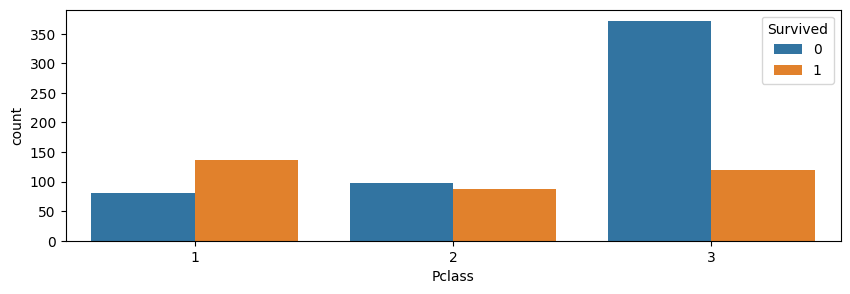

In [8]:
get_value_counts("Pclass")

- Here we see passanger class 1, In class 2 the passanger survived and non_survived nearly equal. But the highest non-survived passangers are in class 3.

<AxesSubplot: xlabel='Sex', ylabel='count'>

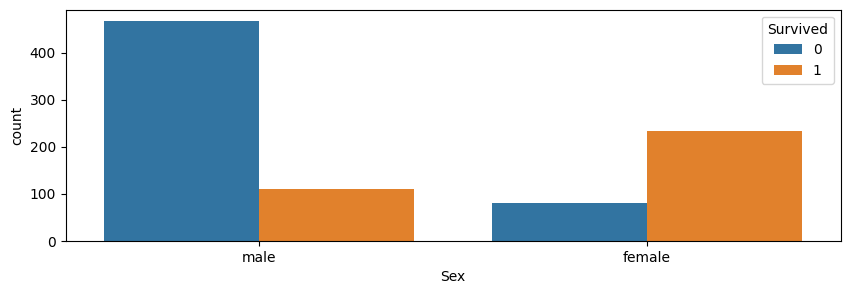

In [9]:
get_value_counts("Sex")

- The death rate of male are much higher than female. Most of the female are survived

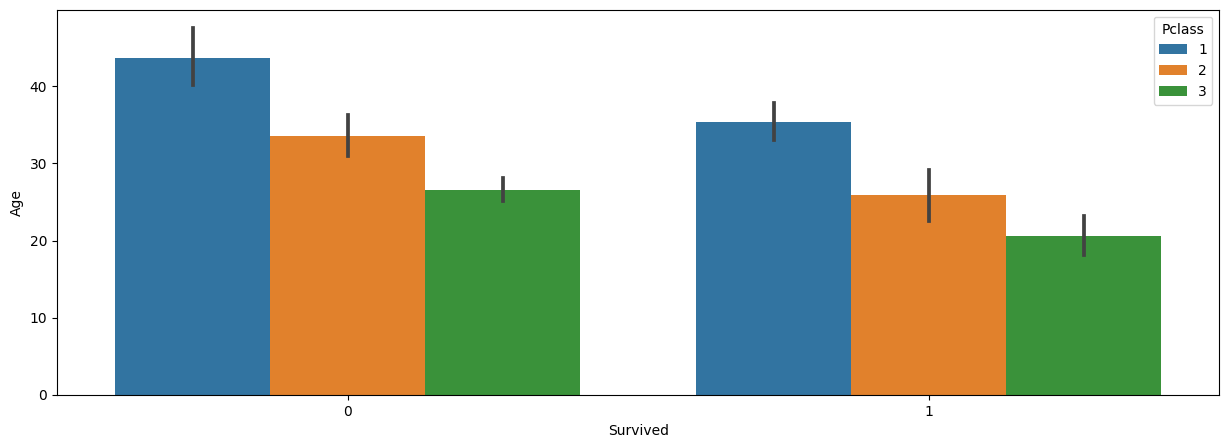

In [14]:
plt.figure(figsize = (15,5))
sns.barplot(x=df["Survived"],y=df["Age"],hue = df["Pclass"])
plt.show()

<AxesSubplot: xlabel='SibSp', ylabel='count'>

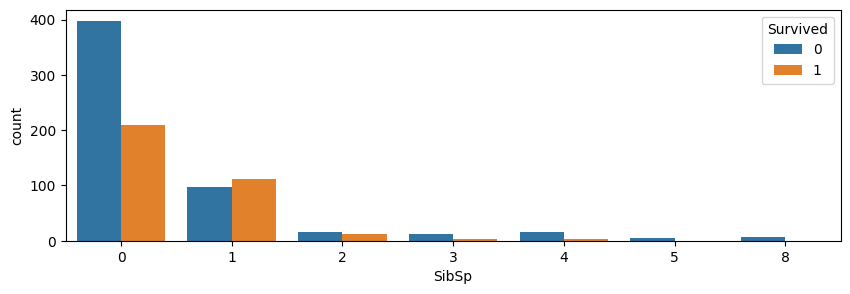

In [15]:
get_value_counts("SibSp")

- people who are travelling alone are highest non_survival. and who has one sibling are survived more then non survived.

<AxesSubplot: xlabel='Parch', ylabel='count'>

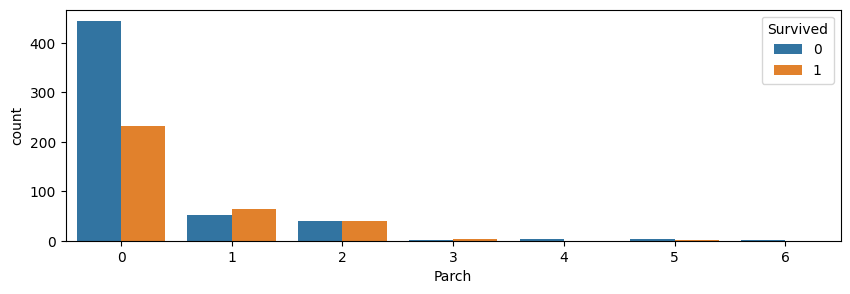

In [16]:
get_value_counts("Parch")

- children who are traveling only with a nanny are the most non_suvived.

<AxesSubplot: xlabel='Embarked', ylabel='count'>

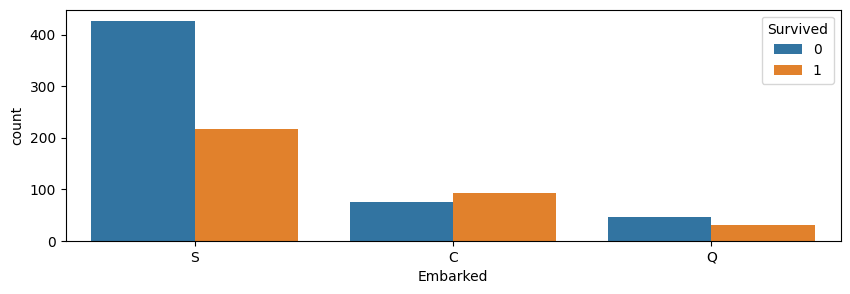

In [17]:
get_value_counts("Embarked")

- Here we can see Port of Embarkation Cherbourg has higer survival rate. Queenstown, Southampton has high non_survival rate.

<AxesSubplot: >

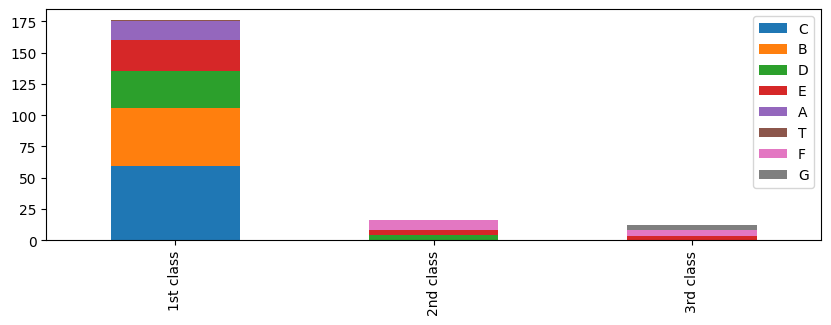

In [28]:
df1 = df
for i in (df1,):
    i["Cabin"] = i["Cabin"].str[0:1]
pcl1 = df1[df1["Pclass"]==1]["Cabin"].value_counts()
pcl2 = df1[df1["Pclass"]==2]["Cabin"].value_counts()
pcl3 = df1[df1["Pclass"]==3]["Cabin"].value_counts()
_temp = pd.DataFrame([pcl1,pcl2,pcl3],index = ["1st class","2nd class","3rd class"])
_temp.plot(kind="bar",stacked = True, figsize=(10,3))

- Here most 1st class passangers are in A cabin then E cabin. And 2nd class passengers are in f cabin. G cabin have the 3rd class passsangers

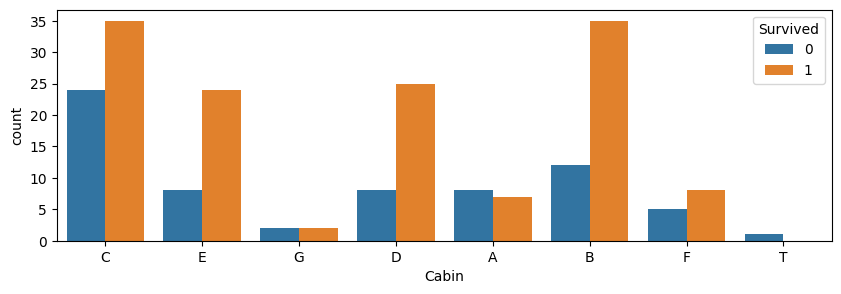

In [27]:
plt.figure(figsize = (10,3))
sns.countplot(x=df1["Cabin"], hue = df1["Survived"])
plt.show()

- Here we can see cabin C is the highest survived and non-survived passangers class, in second place comes class B

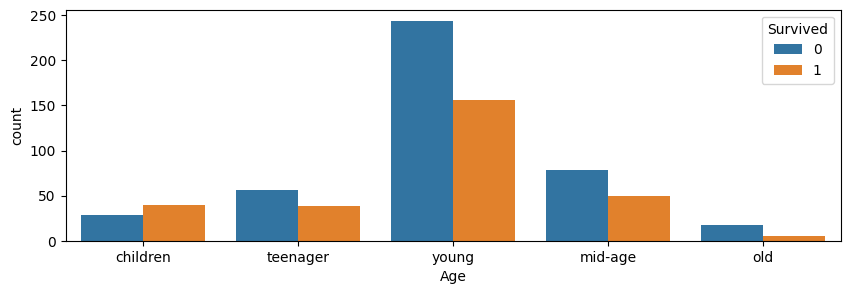

In [30]:
_temp = df.copy()
label = ["children","teenager","young","mid-age","old"]
bin1 = [0,12,19,40,60,90]
_temp["Age"] = pd.cut(x = _temp["Age"], bins = bin1, labels = label) # cutting ages, assigning bins, labels
plt.figure(figsize = (10,3))
sns.countplot(x=_temp["Age"], hue = _temp["Survived"])
plt.show()

- As we see most of non-survived were young-age, followed by mid-age. Also most survived were young people  

---
## Feature Engineering

In [31]:
df_te = df.copy()
df_tr = test_df.copy()

##### first we will drop the irrelevant features.

- passegerid has all unique values.
- fare has no information regarding survived as we already has p class.
- name has no effect on survival
- ticket is not taking part in defining survival
- cabin is also highly co rellated with p class

In [32]:
df.drop(["PassengerId", "Fare", "Name", "Ticket","Cabin",],axis = 1,inplace = True)
test_df.drop(["PassengerId", "Fare", "Name", "Ticket","Cabin",],axis = 1, inplace = True)
df.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S


##### Changing Age Feature into Categorical Feature

In [33]:
label = ["children","teenager","young","mid-age","old"]
bin1 = [0,12,19,40,60,90]
df["Age"] = pd.cut(x = df["Age"], bins = bin1, labels = label) # on training data
test_df["Age"] = pd.cut(x = test_df["Age"], bins = bin1, labels = label) # on testing data
test_df.head(1)

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,young,0,0,Q


##### Handling the missing value

##### We will use mode for categorical featue

In [34]:
df["Age"].fillna(mode(df["Age"])[0][0], inplace = True)
df["Embarked"].fillna(mode(df["Embarked"])[0][0], inplace = True) # most frequent value, only keeping the mode value and not its count

# filling missing values in testing dataset
test_df["Age"].fillna(mode(test_df["Age"])[0][0], inplace = True)

##### Encoding of the features

- we will use replace function for ordinal data
- we will use onhot encoder for nominal data

In [36]:
# using replace function for ordinal data
df.replace({"children":0,"teenager":1,"young":2,
            "mid-age":3,"old":4},inplace = True) # on training data
test_df.replace({"children":0,"teenager":1,
                 "young":2,"mid-age":3,"old":4},inplace = True) # on testing data

In [38]:
# using one-hot encoder for nominal data
ohe = OneHotEncoder()
'''takes a categorical variable with multiple categories and creates a new binary column for each category.'''
df[list(df["Sex"].unique())] = ohe.fit_transform(df[["Sex"]]).A
df[list(df["Embarked"].unique())] = ohe.fit_transform(df[["Embarked"]]).A

#using on testing data
test_df[list(test_df["Sex"].unique())] = ohe.fit_transform(test_df[["Sex"]]).A
test_df[list(test_df["Embarked"].unique())] = ohe.fit_transform(test_df[["Embarked"]]).A

In [39]:
df.drop(["Sex","Embarked"],axis = 1, inplace = True)
test_df.drop(["Sex","Embarked"],axis = 1, inplace = True)

In [40]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,male,female,S,C,Q
0,0,3,2,1,0,0.0,1.0,0.0,0.0,1.0
1,1,1,2,1,0,1.0,0.0,1.0,0.0,0.0
2,1,3,2,0,0,1.0,0.0,0.0,0.0,1.0
3,1,1,2,1,0,1.0,0.0,0.0,0.0,1.0
4,0,3,2,0,0,0.0,1.0,0.0,0.0,1.0


---
## Model Selection and Training

In [44]:
# Preparing the data for modeling
X = df.drop("Survived",axis = 1) # feature
y = df["Survived"]               # target

In [47]:
# Valancing the data
sm = SMOTE(sampling_strategy=0.75) # SMOTE will generate enough synthetic samples so that the minority class makes up 75% of the total samples
sm_X,sm_y = sm.fit_resample(X,y)   # apply SMOTE to the feature and target data.
sm_y.value_counts()                # counted to verify that it has been balanced.

0    549
1    411
Name: Survived, dtype: int64

In [50]:
# spliting the data for training as well as validation purposes
X_train,X_test,y_train,y_test = train_test_split(sm_X,sm_y,test_size=0.2, random_state=45,stratify=sm_y)

In [51]:
lst = [("LogisticRegression",LogisticRegression()),
       ("KNN Classifier", KNeighborsClassifier()),
       ("Decision Tree",DecisionTreeClassifier()),
       ("RandomForest",RandomForestClassifier()),
      ("AdaBoost",AdaBoostClassifier()),
      ("XGBoost",XGBClassifier())]
for name,model in lst:
    model.fit(x_train,y_train)
    y1 = model.predict(x_train)
    accuracy = accuracy_score(y_train,y1)
    y2 = model.predict(x_test)
    acc_te = accuracy_score(y_test,y2)
    print(f"For {name}::\nThe Training Accuracy is: {accuracy}\nThe Testing Accuracy is: {acc_te}")
    print("--"*40)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values